Gayatri Sanjay Awate

In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")
 
%matplotlib inline

In [ ]:
df = pd.read_csv('covid19tweets.csv',encoding = 'latin')

In [ ]:
ndf = pd.read_csv('unktweets.csv',encoding = 'latin')

# **Reviewing Our Dataset**

In [ ]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


In [ ]:
ndf.head()

,ï»¿UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,44904,89856,"Los Angeles, CA",14-04-2020,Essential items are made available at the supermarket. Go help yourself. Maintaina safe distance. Put your mask on. The coronavirus is real and serious.,Neutral
1,44905,89857,North Essex,14-04-2020,"Due to the Covid-19 situation, we have started donating food items to the needy. \r\rMany people came to us for contributing their share of help. We thank you for your contribution during this tim...",Positive
2,44906,89858,California,14-04-2020,"Me, ready to go to picnic during the covid19 outbreak.\r\r\nNothing can stop me. I don't wish to live a life in a quarantine. The coronavirus is a serious thing, but not for me. I hate the virus.",Negative


In [ ]:
df["Sentiment"]= df["Sentiment"].replace('Extremely Positive','Positive') 
df["Sentiment"]= df["Sentiment"].replace('Extremely Negative','Negative') 

In [ ]:
# There are null values in location column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
# There 41157 rows and 6 columns in our database
df.shape

(41157, 6)

In [ ]:
# Names Of columns in our dataset
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

# Going deeper into tweet and sentiment.

In [ ]:
df[df['Sentiment']=='Negative'].head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Negative
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our h...",Negative
20,3819,48771,southampton soxx xxx,16-03-2020,with 100 nations inficted with covid 19 the world must not play fair with china 100 goverments must demand china adopts new guilde lines on food safty the chinese goverment is guilty...,Negative
24,3823,48775,Downstage centre,16-03-2020,@10DowningStreet @grantshapps what is being done to ensure food and other essential products are being re-stocked at supermarkets and panic buying actively discouraged? It cannot be left to checko...,Negative
26,3825,48777,"Ketchum, Idaho",16-03-2020,"In preparation for higher demand and a potential food shortage, The Hunger Coalition purchased 10 percent more food and implemented new protocols due to the COVID-19 coronavirus. https://t.co/5Cec...",Negative


In [ ]:
df[df['Sentiment']=='Neutral'].head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
10,3809,48761,"Makati, Manila",16-03-2020,"All month there hasn't been crowding in the supermarkets or restaurants, however reducing all the hours and closing the malls means everyone is now using the same entrance and dependent on a singl...",Neutral
16,3815,48767,Saudi Arabia,16-03-2020,????? ????? ????? ????? ??\r\r\n?????? ????? ??????? ????????? ?\r\r\n#????_???? ????? ???? ?????? ? #????????? ?????? ?? 13 ???? ?? ?? ???? ?????? ?? ??\r\r\n#???_???????? ????? ??? ???? ? https:...,Neutral
17,3816,48768,"Ontario, Canada",16-03-2020,"@eyeonthearctic 16MAR20 Russia consumer surveillance watchdog reported case in high Arctic where a man who traveled to Iran has COVID-19 and 101 are ""observed""\r\r\nhttps://t.co/4WnrrK9oKC https:/...",Neutral


In [ ]:
df[df['Sentiment']=='Positive'].head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and ot...",Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive


In [ ]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

# Looking For Null Values

Only Location column contains 28% null values. But this column is not useful for our sentiment analysis.Hence we will neglect these null values.

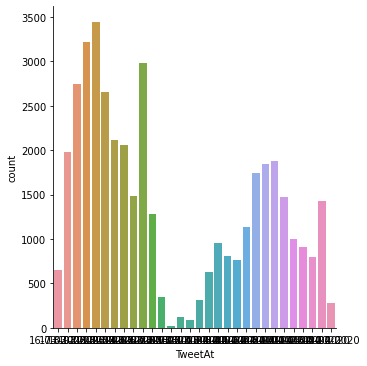

In [ ]:
sns.catplot("TweetAt", data=df, kind="count")

In [ ]:
time_analysis = pd.DataFrame(df['TweetAt'].value_counts().sort_values(ascending=True))
time_analysis = time_analysis.rename(columns={'TweetAt':'count'})

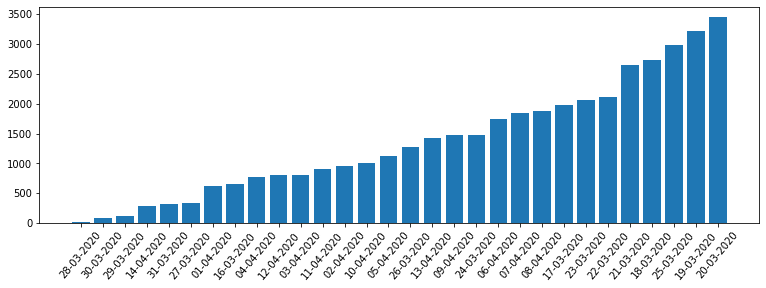

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,3))
ax = fig.add_axes([0,0,1,1])
langs = time_analysis.index[:]
students = time_analysis['count'][:]
ax.bar(langs,students)
plt.xticks(rotation=50)
plt.show()


# Top 10 locations of tweet

In [ ]:
Top_Location_Of_tweet= df['Location'].value_counts().head(10)
sns.set_style('white')

In [ ]:
Top_Location_Of_tweet.head(10)

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

In [ ]:
Top_Location_Of_tweet_df=pd.DataFrame(Top_Location_Of_tweet)
Top_Location_Of_tweet_df.reset_index(inplace=True)
Top_Location_Of_tweet_df.rename(columns={'index':'Location', 'Location':'Location_Count'}, inplace=True)
Top_Location_Of_tweet_df

,Location,Location_Count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


[Text(0, 0, 'London'),
 Text(0, 0, 'United States'),
 Text(0, 0, 'London, England'),
 Text(0, 0, 'New York, NY'),
 Text(0, 0, 'Washington, DC'),
 Text(0, 0, 'United Kingdom'),
 Text(0, 0, 'Los Angeles, CA'),
 Text(0, 0, 'India'),
 Text(0, 0, 'UK'),
 Text(0, 0, 'Australia')]

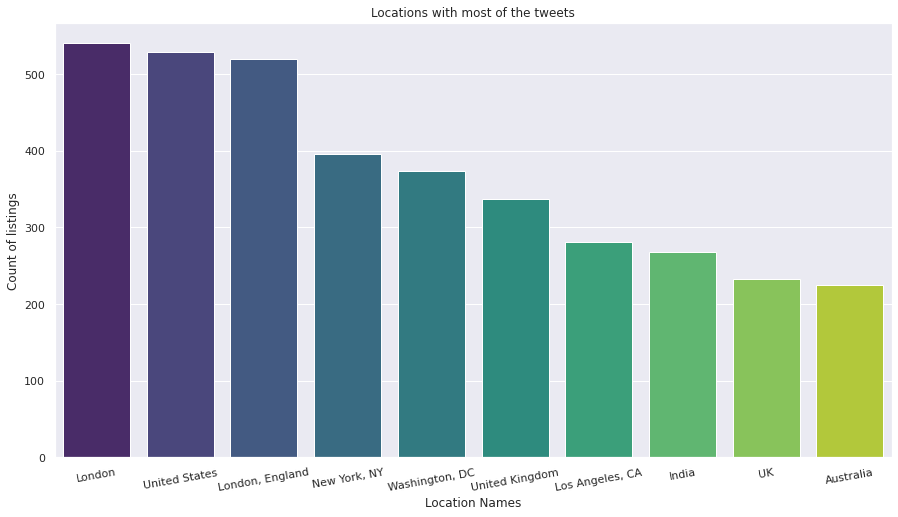

<Figure size 432x288 with 0 Axes>

In [ ]:
viz_1=sns.barplot(x="Location", y="Location_Count", data=Top_Location_Of_tweet_df,
                 palette='viridis')
viz_1.set_title('Locations with most of the tweets')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Location Names')
plt.figure(figsize=(6,4)) 
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=10)

# Sentiments Countplot

In [ ]:
df['Sentiment'].value_counts()

Positive    18046
Negative    15398
Neutral      7713
Name: Sentiment, dtype: int64

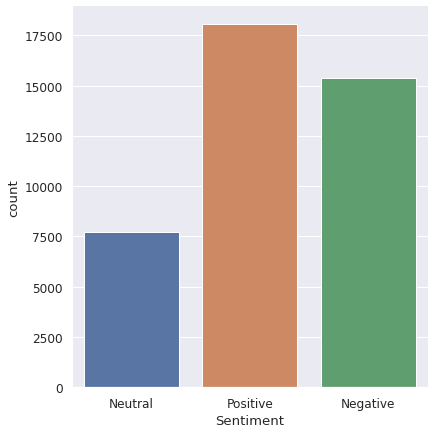

In [ ]:
sns.set(font_scale=1.1)
sns.catplot("Sentiment", data=df, kind="count", height=6)

# Data Preprocessing

**A) Removing @user**

In [ ]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [ ]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [ ]:
# create new column with removed @user
ndf['Tweet'] = np.vectorize(remove_pattern)(ndf['OriginalTweet'], '@[\w]*')

In [ ]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...


**REMOVED HTTP AND URLS FROM TWEET**

In [ ]:
import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [ ]:
ndf['Tweet'] = ndf['OriginalTweet']
ndf['Tweet'] = ndf['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
ndf.head()

,ï»¿UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,44904,89856,"Los Angeles, CA",14-04-2020,Essential items are made available at the supermarket. Go help yourself. Maintaina safe distance. Put your mask on. The coronavirus is real and serious.,Neutral,Essential items are made available at the supermarket. Go help yourself. Maintaina safe distance. Put your mask on. The coronavirus is real and serious.
1,44905,89857,North Essex,14-04-2020,"Due to the Covid-19 situation, we have started donating food items to the needy. \r\rMany people came to us for contributing their share of help. We thank you for your contribution during this tim...",Positive,"Due to the Covid-19 situation, we have started donating food items to the needy. \r\rMany people came to us for contributing their share of help. We thank you for your contribution during this tim..."
2,44906,89858,California,14-04-2020,"Me, ready to go to picnic during the covid19 outbreak.\r\r\nNothing can stop me. I don't wish to live a life in a quarantine. The coronavirus is a serious thing, but not for me. I hate the virus.",Negative,"Me, ready to go to picnic during the covid19 outbreak.\r\r\nNothing can stop me. I don't wish to live a life in a quarantine. The coronavirus is a serious thing, but not for me. I hate the virus."


In [ ]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak"


**B) Removing Punctuations, Numbers, and Special Characters**

In [ ]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

In [ ]:
df.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,Coronavirus Australia Woolworths to give elderly disabled dedicated shopping hours amid COVID outbreak


In [ ]:
# remove special characters, numbers, punctuations
ndf['Tweet'] = ndf['Tweet'].str.replace('[^a-zA-Z#]+',' ')
ndf.head()

NameError: ignored

In [ ]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [ ]:
# remove short words
ndf['Tweet'] = ndf['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

**C) Removing Short Words**

In [ ]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk your neighbours family exchange phone numbers create contact list with phone numbers neighbours schools employer chemist set online shopping accounts poss adequate supplies regular med...


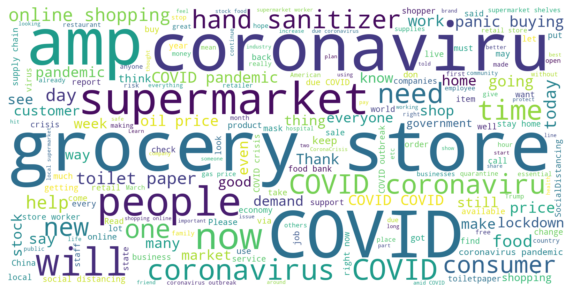

In [ ]:
# create text from all tweets
all_words = ' '.join([text for text in df['Tweet']])

from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white',width=1600, height=800,max_font_size=200,colormap='viridis').generate(all_words) 
plt.figure(figsize=(10,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

**D) Tokenization**

In [ ]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

In [ ]:
# create new variable tokenized tweet 
tokenized = ndf['Tweet'].apply(lambda x: x.split())

In [ ]:
tokenized_tweet

0                                                                                                                                                                                                             []
1        [advice, Talk, your, neighbours, family, exchange, phone, numbers, create, contact, list, with, phone, numbers, neighbours, schools, employer, chemist, set, online, shopping, accounts, poss, adequ...
2                                                                                               [Coronavirus, Australia, Woolworths, give, elderly, disabled, dedicated, shopping, hours, amid, COVID, outbreak]
3        [food, stock, not, the, only, one, which, empty, PLEASE, don, panic, THERE, WILL, ENOUGH, FOOD, FOR, EVERYONE, you, not, take, more, than, you, need, Stay, calm, stay, safe, #COVID, france, #COVID...
4        [ready, supermarket, during, the, #COVID, outbreak, Not, because, paranoid, but, because, food, stock, litteraly, empty, The, #coronavirus, serious, thing,

In [ ]:
tokenized

0                                               [Essential, items, are, made, available, the, supermarket, help, yourself, Maintaina, safe, distance, Put, your, mask, The, coronavirus, real, and, serious]
1    [Due, the, Covid, situation, have, started, donating, food, items, the, needy, Many, people, came, for, contributing, their, share, help, thank, you, for, your, contribution, during, this, time, a...
2                                    [ready, picnic, during, the, covid, outbreak, Nothing, can, stop, don, wish, live, life, quarantine, The, coronavirus, serious, thing, but, not, for, hate, the, virus]
Name: Tweet, dtype: object

**E) Stemming**

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized = tokenized.apply(lambda x: [stemmer.stem(i) for i in x])

In [ ]:
tokenized_tweet

0                                                                                                                                                                                                             []
1        [advic, talk, your, neighbour, famili, exchang, phone, number, creat, contact, list, with, phone, number, neighbour, school, employ, chemist, set, onlin, shop, account, poss, adequ, suppli, regula...
2                                                                                                            [coronaviru, australia, woolworth, give, elderli, disabl, dedic, shop, hour, amid, covid, outbreak]
3        [food, stock, not, the, onli, one, which, empti, pleas, don, panic, there, will, enough, food, for, everyon, you, not, take, more, than, you, need, stay, calm, stay, safe, #covid, franc, #covid, #...
4        [readi, supermarket, dure, the, #covid, outbreak, not, becaus, paranoid, but, becaus, food, stock, litterali, empti, the, #coronaviru, seriou, thing, but, 

In [ ]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# change df['Tweet'] to tokenized_tweet

In [ ]:
# join tokens into one sentence
for i in range(len(tokenized)):
    tokenized[i] = ' '.join(tokenized[i])
# change df['Tweet'] to tokenized_tweet

In [ ]:
df['Tweet']  = tokenized_tweet
df['Tweet']

0                                                                                                                                                                                                               
1             advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order
2                                                                                                                         coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak
3        food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...
4        readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus 

In [ ]:
ndf['Tweet']  = tokenized
ndf['Tweet']

0                                                                             essenti item are made avail the supermarket help yourself maintaina safe distanc put your mask the coronaviru real and seriou
1    due the covid situat have start donat food item the needi mani peopl came for contribut their share help thank you for your contribut dure thi time and encourag maximum peopl good deed the time need
2                                                                     readi picnic dure the covid outbreak noth can stop don wish live life quarantin the coronaviru seriou thing but not for hate the viru
Name: Tweet, dtype: object

In [ ]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order


# **Story Generation and Visualization from Tweets**

*  What are the most common words in the entire dataset?

*  What are the most common words in the dataset for negative and positive tweets, respectively?

*  How many hashtags are there in a tweet?

*  Which trends are associated with my dataset?

*  Which trends are associated with either of the sentiments? Are they compatible with the sentiments?

A) **Understanding the common words used in the tweets: WordCloud**

In [ ]:
df.head(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...


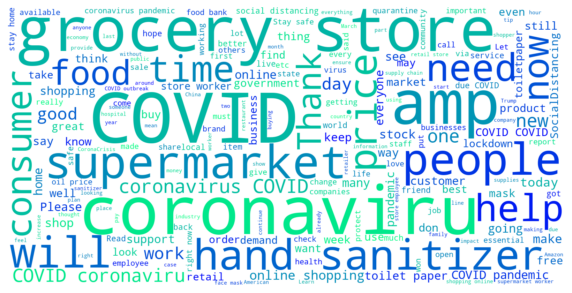

In [ ]:
# create text from just normal tweets

normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Positive']])

wordcloud = WordCloud(background_color='white',width=1600, height=800,max_font_size=200,colormap='winter').generate(normal_words) 
plt.figure(figsize=(10,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

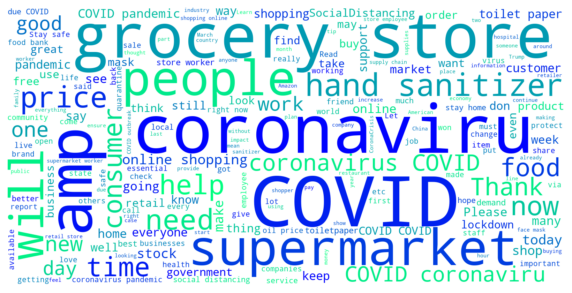

In [ ]:
# create text from just normal tweets

normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Positive']])

wordcloud = WordCloud(background_color='white',width=1600, height=800,max_font_size=200,colormap='winter').generate(normal_words) 
plt.figure(figsize=(10,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

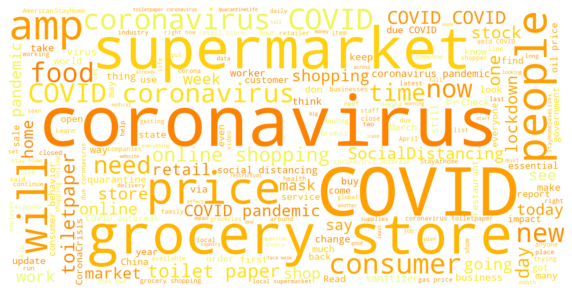

In [ ]:
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Neutral']])

wordcloud = WordCloud(background_color='white',width=1600, height=800,max_font_size=200,colormap='Wistia').generate(normal_words) 
plt.figure(figsize=(10,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

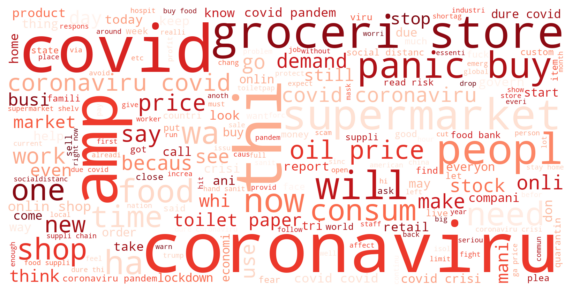

In [ ]:
# create text from just normal tweets
normal_words = ' '.join([text for text in df['Tweet'][df['Sentiment'] == 'Negative']])

wordcloud = WordCloud(background_color='white',width=1600, height=800,max_font_size=200,colormap='Reds_r').generate(normal_words) 
plt.figure(figsize=(10,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

**D) Understanding the impact of Hashtags on tweets sentiment**

In [ ]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
    return hashtags

In [ ]:
# extracting hashtags from non racist/sexist tweets
HT_Positive = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Positive'])
HT_Neutral = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Neutral'])
HT_Negative = hashtag_extract(df['OriginalTweet'][df['Sentiment'] == 'Negative'])


# unnesting list
HT_Positive = sum(HT_Positive, [])
HT_Neutral = sum(HT_Neutral, [])
HT_Negative = sum(HT_Negative,[])

In [ ]:
HT_all = hashtag_extract(df['OriginalTweet'])
print(HT_all)

[[], [], [], ['COVID19france', 'COVID_19', 'COVID19', 'coronavirus', 'confinement', 'Confinementotal', 'ConfinementGeneral'], ['COVID19', 'coronavirus', 'CoronavirusFrance', 'restezchezvous', 'StayAtHome', 'confinement'], [], ['Covid_19'], ['Rebel', 'toiletpapercrisis', 'covid_19'], [], ['govindia', 'IndiaFightsCorona'], ['manila', 'lockdown', 'covid2019', 'Philippines'], [], ['horningsea'], ['CoronaVirus'], [], ['coronavirus', 'covid19'], [], [], [], [], [], [], ['COVID2019', 'Trials', 'Monthly', 'Yearly', 'Prices', 'Subscriptions', 'bestiptv', 'iptv', 'Service', 'Iptv', 'iptvdeals', 'Cheap', 'ipTV', 'Football', 'HD', 'Movies', 'Adult', 'Cinema', 'hotmovies', 'iptvnew', 'iptv2020', 'Adult'], ['COVID2019', 'Trials', 'Monthly', 'Yearly', 'Prices', 'Subscriptions', 'bestiptv', 'iptv', 'Service', 'Iptv', 'iptvdeals', 'Cheap', 'ipTV', 'Football', 'HD', 'Movies', 'Adult', 'Cinema', 'hotmovies', 'ipTv', '18Movies'], [], ['consumer', 'covid19', 'tracker'], [], [], ['COVID19', 'CovidNYC'], ['C

In [ ]:
HT_all=sum(HT_all,[])

In [ ]:
print(HT_Positive)

['COVID19france', 'COVID_19', 'COVID19', 'coronavirus', 'confinement', 'Confinementotal', 'ConfinementGeneral', 'Covid_19', 'horningsea', 'CoronaVirus', 'coronavirus', 'covid19', 'COVID2019', 'Trials', 'Monthly', 'Yearly', 'Prices', 'Subscriptions', 'bestiptv', 'iptv', 'Service', 'Iptv', 'iptvdeals', 'Cheap', 'ipTV', 'Football', 'HD', 'Movies', 'Adult', 'Cinema', 'hotmovies', 'iptvnew', 'iptv2020', 'Adult', 'COVID2019', 'Trials', 'Monthly', 'Yearly', 'Prices', 'Subscriptions', 'bestiptv', 'iptv', 'Service', 'Iptv', 'iptvdeals', 'Cheap', 'ipTV', 'Football', 'HD', 'Movies', 'Adult', 'Cinema', 'hotmovies', 'ipTv', '18Movies', 'consumer', 'covid19', 'tracker', 'BreakingNews', 'Breaking', 'Coronavirus', 'CoronavirusOutbreak', 'COVID19', 'COVID', 'COVID_19', 'COVID2019', 'Collapse', 'CoronavirusOutbreak', 'coronavirus', 'COVID2019', 'COVID19', 'CoronavirusOutbreak', 'COVID2019', 'jlmco', 'jlmcobrand', 'coronapocolypse', 'coronavirus', 'CoronavirusOutbreak', 'COVID19', 'shoponline', 'economy'

In [ ]:
print(HT_Neutral)

['Rebel', 'toiletpapercrisis', 'covid_19', 'manila', 'lockdown', 'covid2019', 'Philippines', 'coronavirus', 'BrickAndMortar', 'COVID2019', 'QuarantineLife', 'CoronavirusOutbreak', 'coronavirus', 'IMadeThisUp', 'FakeNews', 'covid_19', 'pandemic', 'socialdistancing', 'retail', 'seafood', 'coronavirus', 'CoronavirusOutbreak', 'CoronavirusReachesDelhi', 'Coronavid19', 'CoronaVirusUpdates', 'COVID2019', 'COVID19', 'JhalakBollywood', 'JhalakKollywood', 'JhalakTollywood', 'coronavirus', 'TrumpIsAnIdiot', 'trumpneedstoshutup', 'coronavirus', 'Priorities', 'CoronaVirus', 'COVID2019', 'retail', 'retailapocalypse2020', 'coronavirus', 'retailnews', 'COVID19', 'Coronavirus', 'LOTL', 'boomers', 'COVID2019', 'SocialDista', 'Dallas', 'coronapocolypse', 'COVID2019', 'CoronaVirusUpdates', 'CoronaVirus', 'immunesystem', 'immunesupport', 'coronavirus', 'covid_19', 'Food', 'coronavirus', 'foodshortage', 'foodsecurity', 'Stockpile', 'Canada', 'Meat', 'hoarding', 'coronavirus', 'nomestleft', 'nofood', 'canad

In [ ]:
print(HT_Negative)

['COVID19', 'coronavirus', 'CoronavirusFrance', 'restezchezvous', 'StayAtHome', 'confinement', 'govindia', 'IndiaFightsCorona', 'COVID19', 'CovidNYC', 'Coronavirus', 'StockUp', 'CoronavirusOutbreak', 'coronavirus', 'houston', 'nofood', 'Notoiletpaper', 'NoHandShakes', 'nohandsanitizer', 'COVID19', 'pandemic', 'totallockdown', 'COVID2019usa', 'walmart', 'CoronaVirusSA', 'Covid_19', 'coronavirus', 'coronavirus', 'Scammers', 'COVID', 'coronavirus', 'cdc', 'flu', 'trends', 'alert', 'nameandshame', 'covid', 'coronavirus', 'Liverpool', 'CoronavirusOutbreak', 'services', 'food', 'delivery', 'coronavirus', 'COVID', 'COVID19Aus', 'coronavirus', 'DontPanicBuy', 'coronavirus', 'coronapocolypse', 'Covid_19', 'panicbuying', 'COVID', 'coronavirus', 'coronavirusuk', 'anxiety', 'panicbuyinguk', 'morons', 'coronavirus', 'panicbuying', 'whatashitshow', 'stoppanickbuying', 'thinkingofothers', 'coronavirus', 'COVID19', 'Covid_19', 'panicshopping', 'pricegougers', 'Idiots', 'COVID2019', 'coronavirus', 'ret

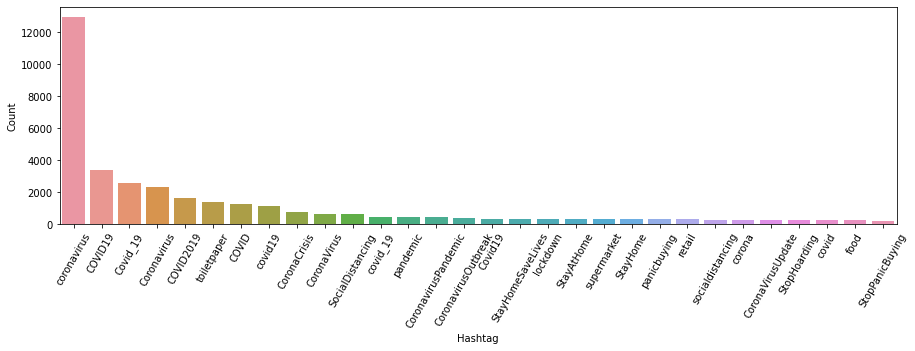

In [ ]:
# making frequency distribution top 30 hashtags
a = nltk.FreqDist(HT_all)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 30)
plt.figure(figsize = (15,4))
plt.xticks(rotation=60)
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

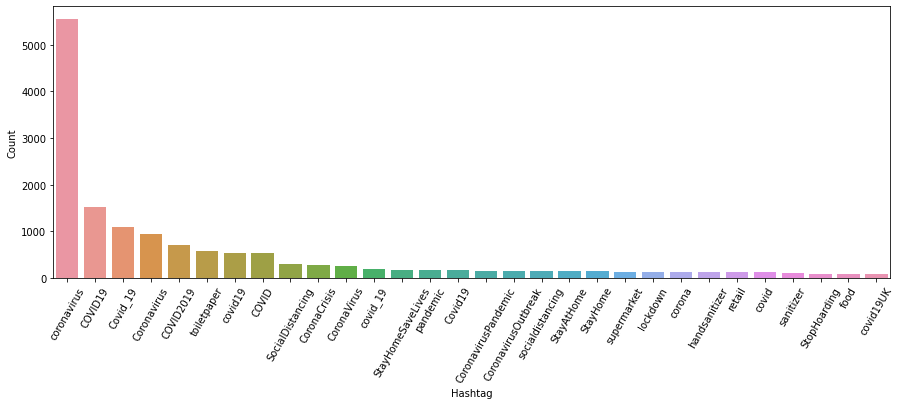

In [ ]:
# making frequency distribution top 10 Positive hashtags
a = nltk.FreqDist(HT_Positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 30)
plt.figure(figsize = (15,5))
plt.xticks(rotation=60)
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

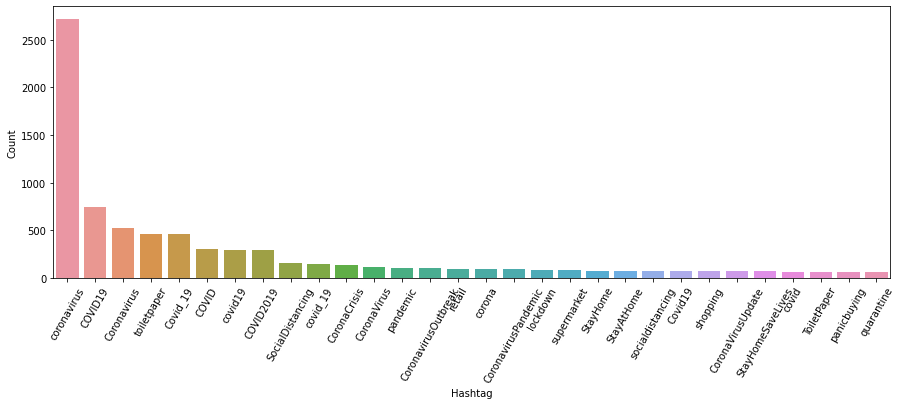

In [ ]:
# making frequency distribution top 10 Neutral hashtags
a = nltk.FreqDist(HT_Neutral)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 30)

plt.figure(figsize = (15,5))
plt.xticks(rotation=60)
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

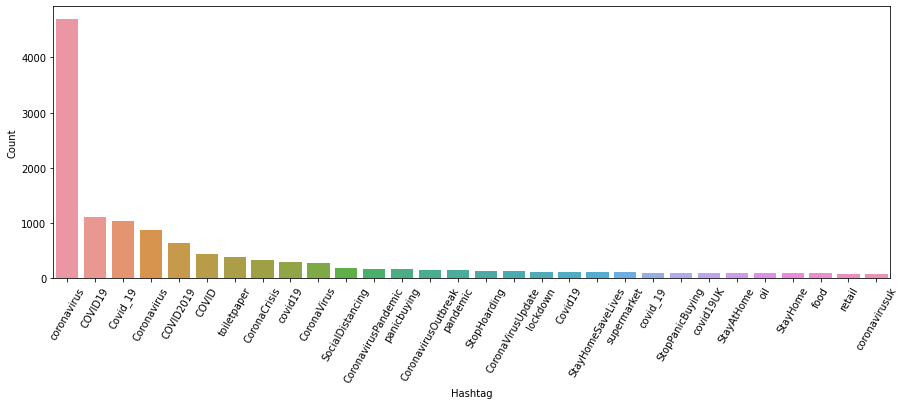

In [ ]:
# making frequency distribution top 10 Negative hashtags
a = nltk.FreqDist(HT_Negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 30)
plt.figure(figsize = (15,5))
plt.xticks(rotation=60)
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.show()

#**Extracting Features from Cleaned Tweets**

In [ ]:
new_df = df[['Tweet','Sentiment']]

In [ ]:
unk = ndf[['Tweet','Sentiment']]

In [ ]:
new_df.head()

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative


In [ ]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

**Converting into lower case**

In [ ]:
#new_df["Tweet"] = new_df["Tweet"].str.lower()#.str.split()

In [ ]:
#new_df.head(5)

**Removing Stopwords**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [ ]:
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0                                                                                                                                                                                                             []
1        [v, c,  , l, k,  , u, r,  , n, e, g, h, b, u, r,  , f, l,  , e, x, c, h, n, g,  , p, h, n, e,  , n, u, b, e, r,  , c, r, e,  , c, n, c,  , l,  , w, h,  , p, h, n, e,  , n, u, b, e, r,  , n, e, g, ...
2                                                            [c, r, n, v, r, u,  , u, r, l,  , w, l, w, r, h,  , g, v, e,  , e, l, e, r, l,  , b, l,  , e, c,  , h, p,  , h, u, r,  ,  , c, v,  , u, b, r, e, k]
3        [f,  , c, k,  , n,  , h, e,  , n, l,  , n, e,  , w, h, c, h,  , e, p,  , p, l, e,  , n,  , p, n, c,  , h, e, r, e,  , w, l, l,  , e, n, u, g, h,  , f,  , f, r,  , e, v, e, r, n,  , u,  , n,  , k, ...
4        [r, e,  , u, p, e, r, r, k, e,  , u, r, e,  , h, e,  , #, c, v,  , u, b, r, e, k,  , n,  , b, e, c, u,  , p, r, n,  , b, u,  , b, e, c, u,  , f,  , c, k,  

In [ ]:
unk['Tweet'].apply(lambda x: [item for item in x if item not in stop])

0    [e, e, n,  , e,  , r, e,  , e,  , v, l,  , h, e,  , u, p, e, r, r, k, e,  , h, e, l, p,  , u, r, e, l, f,  , n, n,  , f, e,  , n, c,  , p, u,  , u, r,  , k,  , h, e,  , c, r, n, v, r, u,  , r, e, ...
1    [u, e,  , h, e,  , c, v,  , u,  , h, v, e,  , r,  , n,  , f,  , e,  , h, e,  , n, e, e,  , n,  , p, e, p, l,  , c, e,  , f, r,  , c, n, r, b, u,  , h, e, r,  , h, r, e,  , h, e, l, p,  , h, n, k, ...
2    [r, e,  , p, c, n, c,  , u, r, e,  , h, e,  , c, v,  , u, b, r, e, k,  , n, h,  , c, n,  , p,  , n,  , w, h,  , l, v, e,  , l, f, e,  , q, u, r, n, n,  , h, e,  , c, r, n, v, r, u,  , e, r, u,  , ...
Name: Tweet, dtype: object

In [ ]:
new_df.head(6)

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Extremely Negative
5,news the region first confirm covid case came out sullivan counti last week peopl flock area store purchas clean suppli hand sanit food toilet paper and other good report,Positive


In [ ]:
new_df.shape

(41157, 2)

In [ ]:
unk.shape

(3, 2)

In [ ]:
new_df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [ ]:
new_df["Sentiment"]= new_df["Sentiment"].replace('Extremely Positive','Positive') 
new_df["Sentiment"]= new_df["Sentiment"].replace('Extremely Negative','Negative') 

In [ ]:
new_df.head(5)

,Tweet,Sentiment
0,,Neutral
1,advic talk your neighbour famili exchang phone number creat contact list with phone number neighbour school employ chemist set onlin shop account poss adequ suppli regular med but not over order,Positive
2,coronaviru australia woolworth give elderli disabl dedic shop hour amid covid outbreak,Positive
3,food stock not the onli one which empti pleas don panic there will enough food for everyon you not take more than you need stay calm stay safe #covid franc #covid #covid #coronaviru #confin #confi...,Positive
4,readi supermarket dure the #covid outbreak not becaus paranoid but becaus food stock litterali empti the #coronaviru seriou thing but pleas don panic caus shortag #coronavirusfr #restezchezv #stay...,Negative


In [ ]:
unk.head(5)

,Tweet,Sentiment
0,essenti item are made avail the supermarket help yourself maintaina safe distanc put your mask the coronaviru real and seriou,Neutral
1,due the covid situat have start donat food item the needi mani peopl came for contribut their share help thank you for your contribut dure thi time and encourag maximum peopl good deed the time need,Positive
2,readi picnic dure the covid outbreak noth can stop don wish live life quarantin the coronaviru seriou thing but not for hate the viru,Negative


# Spitting Our Dataset into Training And Testing Dataset ( For Multiclass Classification)

In [ ]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(new_df,test_size = 0.2,random_state=0,stratify = new_df.Sentiment.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (32925, 2)
valid shape :  (8232, 2)


# Use Of Counter Vectorizer For Multi Class Classification

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet.values)
X_valid = vectorizer.transform(valid.Tweet.values)

y_train = train.Sentiment.values
y_valid = valid.Sentiment.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (32925, 27114)
X_train.shape :  (8232, 27114)
y_train.shape :  (32925,)
y_valid.shape :  (8232,)


In [ ]:

print(unk)
Xunk = vectorizer.transform(unk.Tweet.values)
yunk = unk.Sentiment.values

                                                                                                                                                                                                    Tweet Sentiment
0                                                                           essenti item are made avail the supermarket help yourself maintaina safe distanc put your mask the coronaviru real and seriou   Neutral
1  due the covid situat have start donat food item the needi mani peopl came for contribut their share help thank you for your contribut dure thi time and encourag maximum peopl good deed the time need  Positive
2                                                                   readi picnic dure the covid outbreak noth can stop don wish live life quarantin the coronaviru seriou thing but not for hate the viru  Negative


In [ ]:
Xunk

<3x27114 sparse matrix of type '<class 'numpy.int64'>'
	with 52 stored elements in Compressed Sparse Row format>

# Naive Bayes Classifier for MULTICLASS Classification

In [ ]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.7800151860288534
Validation accuracy Score :  0.6845238095238095
              precision    recall  f1-score   support

    Negative       0.76      0.68      0.72      3428
     Neutral       0.26      0.70      0.38       571
    Positive       0.80      0.69      0.74      4233

    accuracy                           0.68      8232
   macro avg       0.61      0.69      0.61      8232
weighted avg       0.75      0.68      0.71      8232



# Stochastic Gradient Descent-SGD Classifier( MULTICLASS CLASSIFICATION)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.9167805618830676
Validation accuracy Score :  0.80988824101069
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82      3030
     Neutral       0.72      0.70      0.71      1577
    Positive       0.85      0.84      0.84      3625

    accuracy                           0.81      8232
   macro avg       0.79      0.79      0.79      8232
weighted avg       0.81      0.81      0.81      8232



In [ ]:

sgd_pred = sgd_clf.predict(Xunk)
print(sgd_pred)


['Positive' 'Positive' 'Negative']


In [ ]:
unk

,Tweet,Sentiment
0,essenti item are made avail the supermarket help yourself maintaina safe distanc put your mask the coronaviru real and seriou,Neutral
1,due the covid situat have start donat food item the needi mani peopl came for contribut their share help thank you for your contribut dure thi time and encourag maximum peopl good deed the time need,Positive
2,readi picnic dure the covid outbreak noth can stop don wish live life quarantin the coronaviru seriou thing but not for hate the viru,Negative
3,nan,NaN
4,nan,NaN
...,...,...
41152,nan,NaN
41153,nan,NaN
41154,nan,NaN
41155,nan,NaN


# RANDOM FOREST CLASSIFIER (For Multiclass Classification)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  0.9964464692482916
Validation accuracy Score :  0.7602040816326531
              precision    recall  f1-score   support

    Negative       0.74      0.79      0.76      2907
     Neutral       0.67      0.68      0.68      1540
    Positive       0.81      0.78      0.79      3785

    accuracy                           0.76      8232
   macro avg       0.74      0.75      0.74      8232
weighted avg       0.76      0.76      0.76      8232



# Extreme Gradient Boosting ( For Multiclass Classification)

In [ ]:
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

Training accuracy Score    :  0.6299772209567198
Validation accuracy Score :  0.624757045675413
              precision    recall  f1-score   support

    Negative       0.65      0.71      0.68      2818
     Neutral       0.04      0.64      0.07        90
    Positive       0.86      0.58      0.69      5324

    accuracy                           0.62      8232
   macro avg       0.51      0.64      0.48      8232
weighted avg       0.78      0.62      0.68      8232



# Support vector machine( For Multiclass Classification)

In [ ]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.9348823082763857
Validation accuracy Score :  0.7738095238095238
              precision    recall  f1-score   support

    Negative       0.78      0.79      0.79      3029
     Neutral       0.65      0.66      0.66      1519
    Positive       0.82      0.80      0.81      3684

    accuracy                           0.77      8232
   macro avg       0.75      0.75      0.75      8232
weighted avg       0.77      0.77      0.77      8232



# Logistic Regression(For Multiclass Classification)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.9318451025056947
Validation accuracy Score :  0.7936103012633625
              precision    recall  f1-score   support

    Negative       0.81      0.81      0.81      3103
     Neutral       0.69      0.68      0.68      1567
    Positive       0.82      0.83      0.83      3562

    accuracy                           0.79      8232
   macro avg       0.77      0.77      0.77      8232
weighted avg       0.79      0.79      0.79      8232



# CATBOOST MODEL (For Multiclass Classification)

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 69.2MB 42kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [ ]:
clf2 = CatBoostClassifier()


clf2.fit(X_train, y_train,  
        eval_set=(X_valid, y_valid), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [ ]:
catboost_prediction = clf2.predict(X_valid)
catboost_accuracy = accuracy_score(y_valid,catboost_prediction)
print("Training accuracy Score    : ",clf2.score(X_train,y_train))
print("Validation accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_valid))

Training accuracy Score    :  0.8274867122247532
Validation accuracy Score :  0.8062439261418853
              precision    recall  f1-score   support

    Negative       0.79      0.84      0.81      2924
     Neutral       0.77      0.69      0.73      1726
    Positive       0.83      0.84      0.83      3582

    accuracy                           0.81      8232
   macro avg       0.80      0.79      0.79      8232
weighted avg       0.81      0.81      0.81      8232



# All the multiclass models test accuracy in descending order

In [ ]:
import pandas as pd
models = pd.DataFrame({
    'Model': ['SVM', 'LogReg', 
              'RF', 'NBs', 
              'SGD', 'XGB','CatB'],
    'Test accuracy': [svc_accuracy*100, logreg_accuracy*100, 
              rf_accuracy*100, NB_accuracy*100, 
              sgd_accuracy*100, xgb_accuracy*100,catboost_accuracy*100]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
4,SGD,80.988824
6,CatB,80.624393
1,LogReg,79.361030
0,SVM,77.380952
2,RF,76.020408
3,NBs,68.452381
5,XGB,62.475705


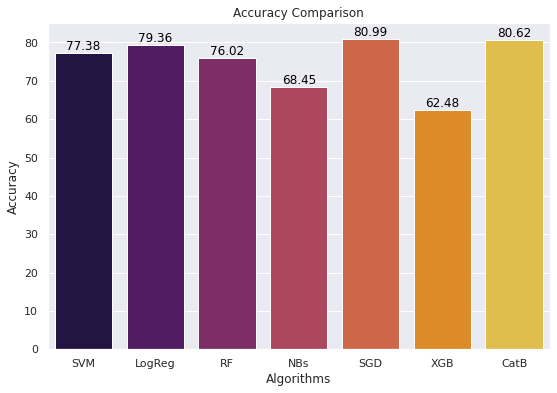

In [ ]:
plt.figure(figsize=[9,6])
plt.title('Accuracy Comparison')

graph=sns.barplot(x =models['Model'] ,y = models['Test accuracy'],palette ='inferno')
plt.ylabel('Accuracy')
plt.xlabel('Algorithms')

for p in graph.patches:
    graph.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')

In [ ]:
predicted_values = sgd_clf.predict(X_valid)

df = pd.DataFrame(list(zip(y_valid,sgd_prediction)),
               columns =['Actual_Sentiment','Predicted_Sentiment'])
print(df)

     Actual_Sentiment Predicted_Sentiment
0            Positive            Positive
1             Neutral             Neutral
2            Positive            Positive
3            Negative            Negative
4            Negative            Negative
...               ...                 ...
8227         Positive            Positive
8228          Neutral             Neutral
8229         Negative             Neutral
8230         Positive            Positive
8231         Positive             Neutral

[8232 rows x 2 columns]


In [ ]:
confusion_matrix(y_valid,sgd_prediction)

array([[2507,  231,  342],
       [ 200, 1110,  233],
       [ 323,  236, 3050]])

In [ ]:
predicted_values = sgd_clf.predict(X_valid)

df = pd.DataFrame(list(zip(y_valid,catboost_prediction)),
               columns =['Actual_Sentiment','Predicted_Sentiment'])
print(df)

     Actual_Sentiment Predicted_Sentiment
0            Positive          [Positive]
1             Neutral           [Neutral]
2            Positive          [Positive]
3            Negative          [Negative]
4            Negative          [Negative]
...               ...                 ...
8227         Positive          [Positive]
8228          Neutral           [Neutral]
8229         Negative           [Neutral]
8230         Positive          [Positive]
8231         Positive           [Neutral]

[8232 rows x 2 columns]


In [ ]:
sgd_pred = sgd_clf.predict(Xunk)
df = pd.DataFrame(list(zip(ndf['OriginalTweet'],sgd_pred)),
                  columns =['Unknown Tweet','SGD_Sentiment'])
df

,Unknown Tweet,SGD_Sentiment
0,Essential items are made available at the supermarket. Go help yourself. Maintaina safe distance. Put your mask on. The coronavirus is real and serious.,Positive
1,"Due to the Covid-19 situation, we have started donating food items to the needy. \r\rMany people came to us for contributing their share of help. We thank you for your contribution during this tim...",Positive
2,"Me, ready to go to picnic during the covid19 outbreak.\r\r\nNothing can stop me. I don't wish to live a life in a quarantine. The coronavirus is a serious thing, but not for me. I hate the virus.",Negative


In [ ]:
confusion_matrix(y_valid,catboost_prediction)

array([[2442,  250,  388],
       [ 156, 1194,  193],
       [ 326,  282, 3001]])

## **UNKNOWN VALUES**

In [ ]:
unk = pd.read_excel('unknown.xlsx')
unk.head()

,Tweet,Sentiment
0,Essential items are made available at the supermarket. Go help yourself. Maintaina safe distance. Put your mask on. The coronavirus is real and serious.,Neutral
1,"Due to the Covid-19 situation, we have started donating food items to the needy. \r\rMany people came to us for contributing their share of help. We thank you for your contribution during this tim...",Positive
2,"Me, ready to go to picnic during the covid19 outbreak.\r\r\nNothing can stop me. I don't wish to live a life in a quarantine. The coronavirus is a serious thing, but not for me. I hate the virus.",Negative
3,NaN,NaN
4,NaN,NaN


In [ ]:
unk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      6 non-null      object
 1   Sentiment  6 non-null      object
dtypes: object(2)
memory usage: 352.0+ bytes


In [ ]:
unk['Tweet'] = unk['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

AttributeError: ignored

In [ ]:
tokenized_tweet = unk['Tweet'].apply(lambda x: x.split())
tokenized_tweet

In [ ]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [ ]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
# change df['Tweet'] to tokenized_tweet
df['Tweet']  = tokenized_tweet
df['Tweet']

In [ ]:
new_df['Tweet'].apply(lambda x: [item for item in x if item not in stop])